In [1]:
import os
import numpy as np
from scipy.spatial import distance
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from mindstorm import dsmplot
from tesser import util
from tesser import figures
from tesser import network

data_dir = '/Users/morton/Dropbox/tesser_successor/Data'
fig_dir = '/Users/morton/Dropbox/tesser_successor/Figures/plots'

In [2]:
group = util.load_group(data_dir)
group.head()

,subject,dim1,dim2,node,community,node_type,connect
0,100,8,14,1,1,0,0
1,100,5,14,2,1,0,0
2,100,5,12,3,1,1,2
3,100,8,13,4,2,1,1
4,100,8,12,5,2,0,0


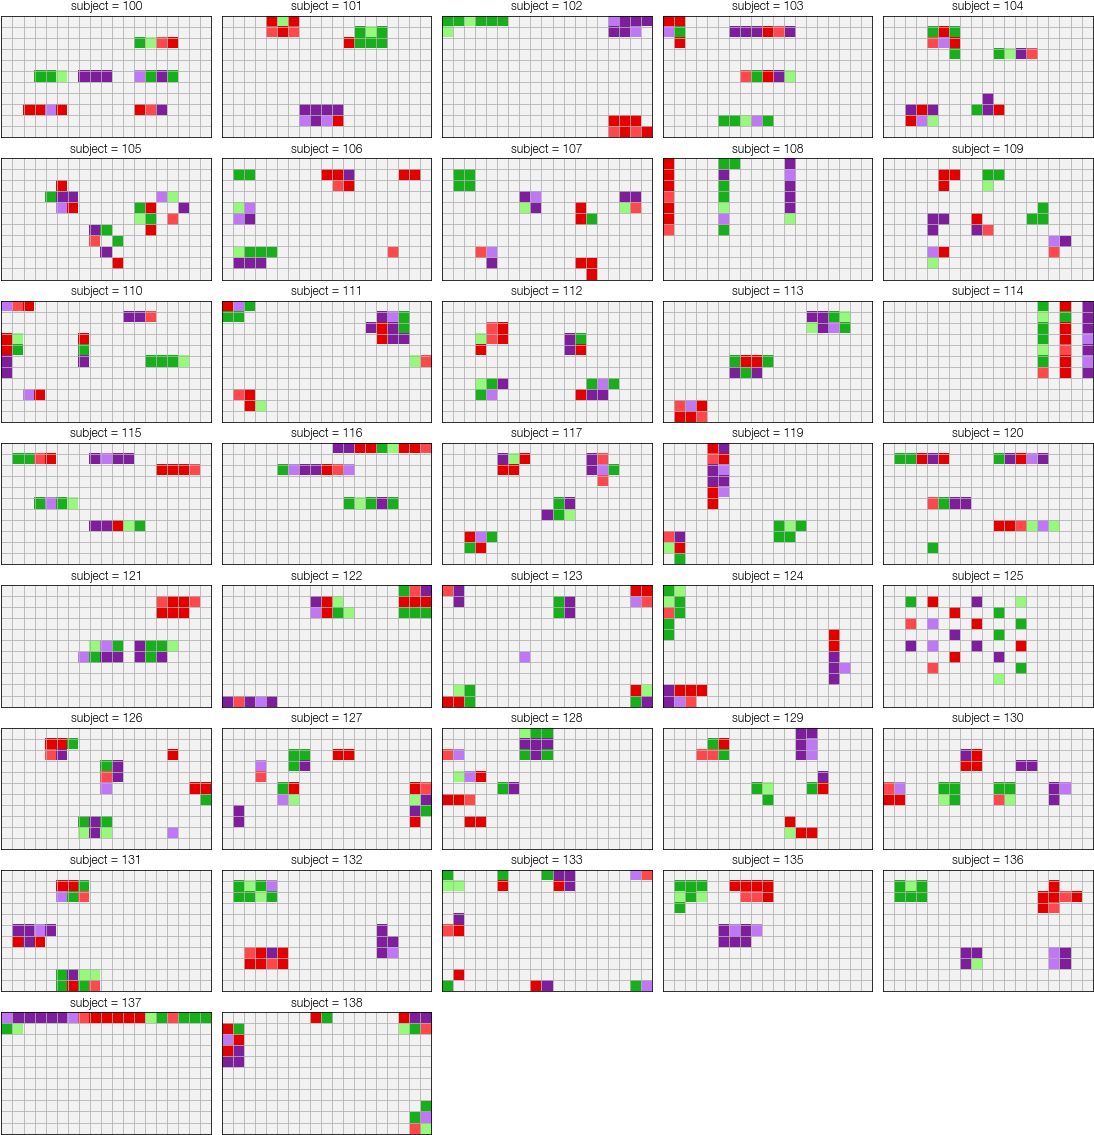

In [3]:
g = sns.FacetGrid(data=group, col='subject', col_wrap=5, aspect=17/11, height=2)
g.map_dataframe(figures.plot_group_mat);
g.savefig(os.path.join(fig_dir, 'grouping.pdf'))

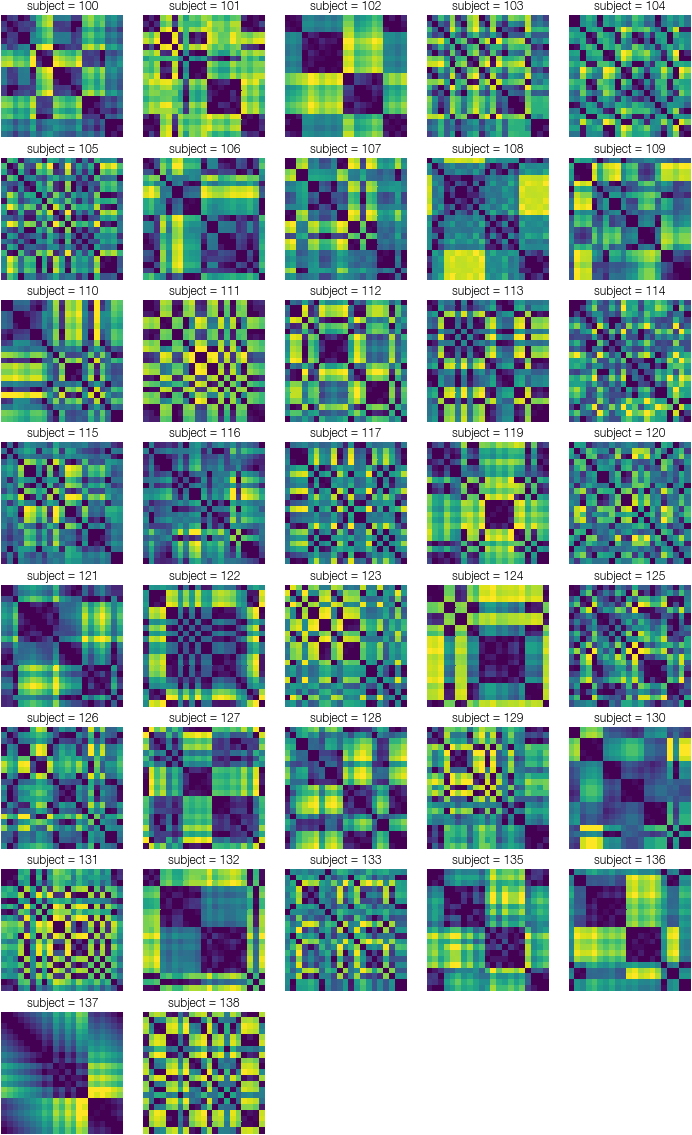

In [4]:
g = sns.FacetGrid(data=group, col='subject', col_wrap=5, height=2)
g.map_dataframe(dsmplot.plot_rep_as_dsm, distance='euclidean');
g.savefig(os.path.join(fig_dir, 'grouping_euclidean.pdf'))

In [5]:
rdv_list = []
for subject, df in group.groupby('subject'):
    coords = df.filter(like='dim').to_numpy()
    subj_rdv = distance.pdist(coords, 'euclidean')
    rdv_list.append(subj_rdv)
rdv = np.vstack(rdv_list)

In [6]:
nodes = network.node_info()
comm = nodes['community'].to_numpy()
within = comm == comm[:, None]
within_vec = distance.squareform(within, checks=False)

In [7]:
m_within = np.mean(rdv[:, within_vec == 1], axis=1)
m_across = np.mean(rdv[:, within_vec == 0], axis=1)
res = pd.DataFrame(
    {'subject': group['subject'].unique(), 'within': m_within, 'across': m_across}
)

In [8]:
pg.ttest(res['across'], res['within'], paired=True)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,4.554845,36,two-sided,0.000058,"[1.0, 2.61]",0.853919,406.56,0.999004


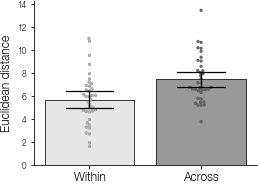

In [9]:
fig, ax = plt.subplots(figsize=(4, 3))
light = [(.9, .9, .9), (.6, .6, .6)]
dark = [(.7, .7, .7), (.4, .4, .4)]
flat = pd.melt(
    res, id_vars='subject', value_vars=['within', 'across'], var_name = 'pair', 
    value_name='distance'
)
figures.plot_swarm_error(flat, x='pair', y='distance', light=light, dark=dark, ax=ax)
ax.set(xticklabels=['Within', 'Across'], ylabel='Euclidean distance');
fig.savefig(os.path.join(fig_dir, 'grouping_distance.pdf'))